In [13]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.unicode_minus'] = False
print("✅ 라이브러리 준비 완료")

✅ 라이브러리 준비 완료


In [6]:
# 딥러닝 클러스터링 결과 (이전 분석 결과)
clusters_dict = {
    0: ['AAPL', 'GOOGL', 'GOOG', 'TSLA', 'AMD', 'AZN', 'SHOP', 'PDD', 'AMGN', 'SNY', 'SNPS', 'IBKR', 'CDNS', 'CSX', 'WDAY', 'ALNY', 'FAST', 'PCAR', 'IDXX', 'EXC', 'EBAY', 'BKR', 'EA', 'KDP', 'MPWR'],
    1: ['COST', 'PLTR', 'LIN', 'ISRG', 'APP', 'GILD', 'ADP', 'ROP', 'CME', 'CTAS', 'EQIX', 'MNST', 'PAYX', 'TRIP'],
    2: ['NVDA', 'MSFT', 'AMZN', 'META', 'AVGO', 'NFLX', 'ASML', 'CSCO', 'TXN', 'INTU', 'BKNG', 'ARM', 'MU', 'AMAT', 'LRCX', 'ADI', 'MELI', 'KLAC', 'DASH', 'CRWD', 'CEG', 'HOOD', 'NTES', 'MDLZ', 'COIN', 'MAR', 'ADSK', 'AXON', 'NDAQ', 'DDOG', 'TTWO', 'ZS'],
    3: ['PEP', 'INTC', 'REGN'],
    4: ['QCOM', 'ADBE', 'CMCSA', 'SBUX', 'ABNB', 'PYPL', 'MRVL', 'NXPI', 'JD', 'TEAM', 'FANG'],
    5: ['HON', 'PANW', 'VRTX', 'TRI', 'FTNT'],
    6: ['TMUS', 'ORLY', 'AEP', 'ROST', 'CPRT', 'KMB', 'XEL', 'ARGX']
}


all_tickers_in_clusters = []
for cluster_tickers in clusters_dict.values():
    all_tickers_in_clusters.extend(cluster_tickers)
all_tickers_in_clusters = sorted(list(set(all_tickers_in_clusters))) # 중복 제거 및 정렬


start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')


print(f"📈 총 {len(all_tickers_in_clusters)}개 종목의 데이터를 수집합니다...")
all_data_px = {}
for ticker in all_tickers_in_clusters:
    try:
        price_df = fdr.DataReader(ticker, start_date, end_date)
        if not price_df.empty:
            all_data_px[ticker] = price_df[['Close']]
    except Exception as e:
        print(f"  - {ticker} 데이터 수집 실패: {e}")


data = pd.concat(all_data_px, axis=1)
data.columns = data.columns.droplevel(1) 

print("\n✅ 데이터 수집 및 준비 완료")
print(data.head())

📈 총 98개 종목의 데이터를 수집합니다...

✅ 데이터 수집 및 준비 완료
                  AAPL        ABNB        ADBE         ADI         ADP  \
2021-12-31  177.570007  166.490005  567.059998  175.770004  246.580002   
2022-01-03  182.009995  172.679993  564.369995  177.149994  244.009995   
2022-01-04  179.699997  170.800003  554.000000  175.550003  245.149994   
2022-01-05  174.919998  162.250000  514.429993  172.839996  243.059998   
2022-01-06  172.000000  159.750000  514.119995  173.389999  241.389999   

                  ADSK        AEP        ALNY        AMAT         AMD  ...  \
2021-12-31  281.190002  88.970001  169.580002  157.360001  143.899994  ...   
2022-01-03  283.720001  88.610001  173.910004  159.929993  150.240005  ...   
2022-01-04  278.190002  88.650002  165.229996  158.360001  144.419998  ...   
2022-01-05  264.320007  89.470001  155.089996  153.740005  136.149994  ...   
2022-01-06  264.109985  89.180000  151.000000  156.339996  136.229996  ...   

                  TMUS         TRI       T

In [7]:
def find_pairs(data, tickers_list, method='cointegration', threshold=0.01):
    pairs = []
    for i in range(len(tickers_list)):
        for j in range(i + 1, len(tickers_list)):
            S1 = data.get(tickers_list[i], pd.Series(dtype=float)).dropna()
            S2 = data.get(tickers_list[j], pd.Series(dtype=float)).dropna()
            
            common_index = S1.index.intersection(S2.index)
            S1 = S1.loc[common_index]
            S2 = S2.loc[common_index]
            
            if len(S1) < 50: continue # 

            score = 0
            if method == 'cointegration':
                _, pvalue, _ = coint(S1, S2)
                score = pvalue
                if score < threshold: 
                    pairs.append((tickers_list[i], tickers_list[j], score))
            
            elif method == 'r_squared':
                model = LinearRegression()
                X_rank = S1.rank(pct=True).values.reshape(-1, 1)
                y_rank = S2.rank(pct=True).values
                model.fit(X_rank, y_rank)
                score = model.score(X_rank, y_rank)
                if score > threshold: 
                    pairs.append((tickers_list[i], tickers_list[j], score))

            elif method == 'mutual_info':
                X = S1.values.reshape(-1, 1)
                y = S2.values
                score = mutual_info_regression(X, y)[0]
                if score > threshold: 
                    pairs.append((tickers_list[i], tickers_list[j], score))

    if method == 'phik':
        if len(tickers_list) > 1:
            phik_matrix = data[tickers_list].phik_matrix(interval_cols=tickers_list)
            upper_tri = phik_matrix.where(np.triu(np.ones(phik_matrix.shape), k=1).astype(bool))
            to_check = upper_tri.stack()
            filtered_pairs = to_check[to_check > threshold] 
            if not filtered_pairs.empty:
                for (row, col), score in filtered_pairs.items():
                    pairs.append((row, col, score))
                    
    return pairs


In [14]:
# ---------------------------
# 4. 각 방법론으로 페어 탐색 실행
# ---------------------------
all_results = {}

# 방법 1: 공적분 (Cointegration)
print("\n--- 1. 공적분(Cointegration) 기반 페어 탐색 (p-value < 0.01) ---")
all_results['cointegration'] = []
for i, cluster in enumerate(clusters_dict.values()):
    pairs = find_pairs(data, cluster, method='cointegration', threshold=0.01)
    if pairs:
        print(f"  [클러스터 {i}]")
        for p in pairs: print(f"    - {p[0]}-{p[1]}: {p[2]:.4f}")
        all_results['cointegration'].extend(pairs)

# 방법 2: 결정계수 (R-squared)
print("\n--- 2. R-squared 기반 페어 탐색 (score > 0.95) ---")
all_results['r_squared'] = []
for i, cluster in enumerate(clusters_dict.values()):
    pairs = find_pairs(data, cluster, method='r_squared', threshold=0.95)
    if pairs:
        print(f"  [클러스터 {i}]")
        for p in pairs: print(f"    - {p[0]}-{p[1]}: {p[2]:.4f}")
        all_results['r_squared'].extend(pairs)

# 방법 3: 상호 정보량 (Mutual Information)
print("\n--- 3. 상호 정보량(Mutual Information) 기반 페어 탐색 (score > 1.5) ---")
all_results['mutual_info'] = []
for i, cluster in enumerate(clusters_dict.values()):
    pairs = find_pairs(data, cluster, method='mutual_info', threshold=1.5)
    if pairs:
        print(f"  [클러스터 {i}]")
        for p in pairs: print(f"    - {p[0]}-{p[1]}: {p[2]:.4f}")
        all_results['mutual_info'].extend(pairs)

# 방법 4: Phik 상관계수
print("\n--- 4. Phik 상관계수 기반 페어 탐색 (score > 0.95) ---")
all_results['phik'] = []
for i, cluster in enumerate(clusters_dict.values()):
    pairs = find_pairs(data, cluster, method='phik', threshold=0.95)
    if pairs:
        print(f"  [클러스터 {i}]")
        for p in pairs: print(f"    - {p[0]}-{p[1]}: {p[2]:.4f}")
        all_results['phik'].extend(pairs)

print("\n✅ 모든 방식의 페어 탐색 완료!")


--- 1. 공적분(Cointegration) 기반 페어 탐색 (p-value < 0.01) ---
  [클러스터 0]
    - AZN-MPWR: 0.0081
    - SHOP-IBKR: 0.0000
    - SHOP-FAST: 0.0000
    - SHOP-BKR: 0.0001
    - SHOP-EA: 0.0035
    - PDD-AMGN: 0.0046
    - PDD-PCAR: 0.0089
    - CSX-EXC: 0.0092
    - WDAY-PCAR: 0.0090
    - EA-MPWR: 0.0070
  [클러스터 2]
    - NVDA-CEG: 0.0037
    - NVDA-ADSK: 0.0083
    - MSFT-INTU: 0.0018
    - AMZN-COIN: 0.0033
    - AVGO-NFLX: 0.0060
    - AVGO-DASH: 0.0025
    - NFLX-BKNG: 0.0063
    - CSCO-AXON: 0.0065
    - TXN-NDAQ: 0.0041
    - INTU-BKNG: 0.0096
    - INTU-KLAC: 0.0013
    - INTU-MAR: 0.0025
    - BKNG-MELI: 0.0054
    - ADI-MELI: 0.0051
    - ADI-KLAC: 0.0075
    - CEG-ADSK: 0.0012
    - MAR-ADSK: 0.0093
    - ADSK-AXON: 0.0003
  [클러스터 4]
    - PYPL-MRVL: 0.0003
    - PYPL-NXPI: 0.0000
    - PYPL-JD: 0.0000
    - PYPL-TEAM: 0.0000
    - PYPL-FANG: 0.0002

--- 2. R-squared 기반 페어 탐색 (score > 0.95) ---
  [클러스터 0]
    - GOOGL-GOOG: 0.9997
  [클러스터 2]
    - NVDA-AVGO: 0.9637
    - NVDA-BKNG: 0.9

📈 선택된 페어: BKNG vs AXON
헤지 비율(Hedge Ratio): 0.17


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_19906/676224742.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = results.params[1]


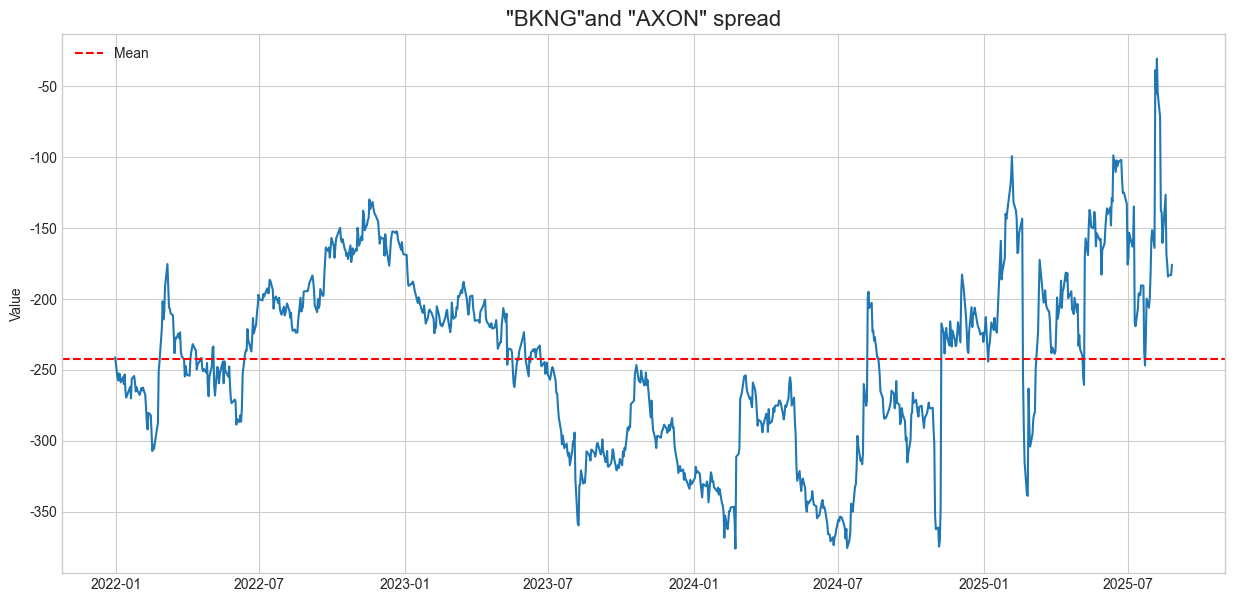

In [22]:
pair_to_analyze = ('BKNG', 'AXON')
print(f"📈 선택된 페어: {pair_to_analyze[0]} vs {pair_to_analyze[1]}")

S1 = data[pair_to_analyze[0]].dropna()
S2 = data[pair_to_analyze[1]].dropna()

# 두 데이터의 날짜 인덱스를 동일하게 맞춥니다.
common_index = S1.index.intersection(S2.index)
S1 = S1.loc[common_index]
S2 = S2.loc[common_index]

# ---------------------------
# 헤지 비율 및 스프레드 계산
# ---------------------------
# 선형 회귀를 통해 두 주가의 최적 비율(hedge ratio)을 계산합니다.
S1_with_const = sm.add_constant(S1)
results = sm.OLS(S2, S1_with_const).fit()
hedge_ratio = results.params[1]
print(f"헤지 비율(Hedge Ratio): {hedge_ratio:.2f}")

# 스프레드 계산: S2 - (Hedge Ratio * S1)
spread = S2 - hedge_ratio * S1

# ---------------------------
# 스프레드 시각화
# ---------------------------
plt.figure(figsize=(15, 7))
plt.plot(spread.index, spread)
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.title(f'"{pair_to_analyze[0]}"and "{pair_to_analyze[1]}" spread', fontsize=16)
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

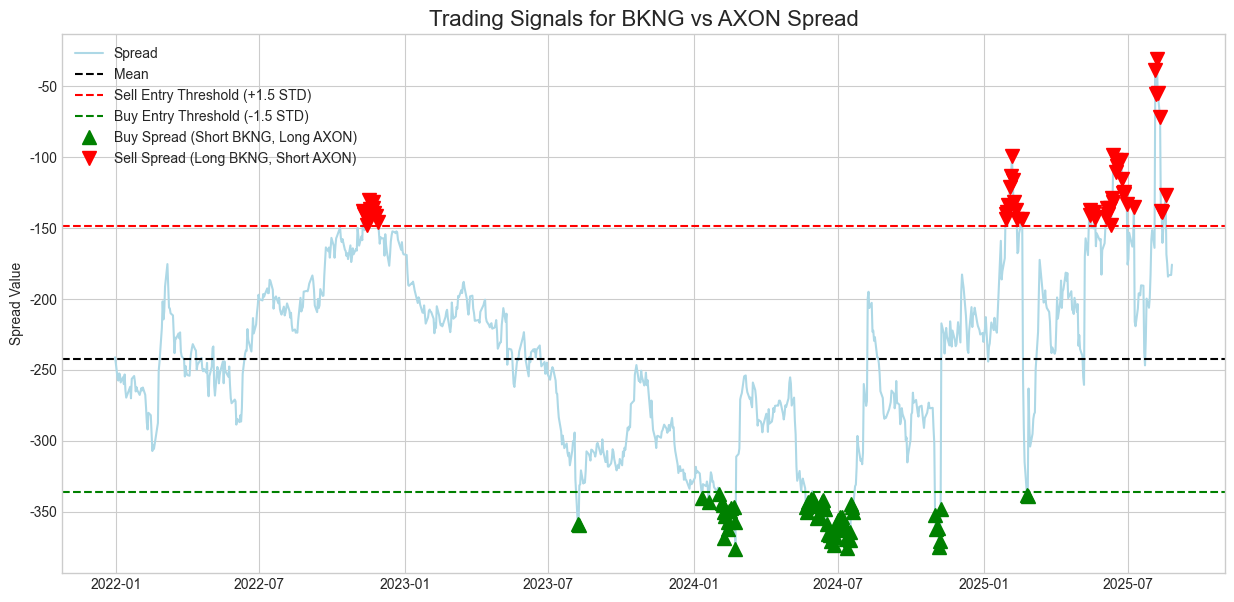

💡 Strategy Explained:
  - **Enter Buy Position**: When the spread drops below the green line, short the relatively overvalued BKNG and long the undervalued AXON.
  - **Enter Sell Position**: When the spread rises above the red line, long the relatively undervalued BKNG and short the overvalued AXON.
  - **Exit Position**: After entering a trade, close both positions to realize profit when the spread reverts to the mean (the black line).


In [23]:
mean_spread = spread.mean()
std_spread = spread.std()


upper_threshold = mean_spread + (1.5 * std_spread)
lower_threshold = mean_spread - (1.5 * std_spread)


plt.figure(figsize=(15, 7))
plt.plot(spread.index, spread, label='Spread', color='lightblue')
plt.axhline(mean_spread, color='black', linestyle='--', label='Mean')
plt.axhline(upper_threshold, color='red', linestyle='--', label='Sell Entry Threshold (+1.5 STD)')
plt.axhline(lower_threshold, color='green', linestyle='--', label='Buy Entry Threshold (-1.5 STD)')


buy_signals = spread[spread < lower_threshold]
sell_signals = spread[spread > upper_threshold]


plt.plot(buy_signals.index, buy_signals, 'g^', markersize=10, label=f'Buy Spread (Short {pair_to_analyze[0]}, Long {pair_to_analyze[1]})')
plt.plot(sell_signals.index, sell_signals, 'rv', markersize=10, label=f'Sell Spread (Long {pair_to_analyze[0]}, Short {pair_to_analyze[1]})')

plt.title(f'Trading Signals for {pair_to_analyze[0]} vs {pair_to_analyze[1]} Spread', fontsize=16)
plt.ylabel('Spread Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

print("💡 Strategy Explained:")
print(f"  - **Enter Buy Position**: When the spread drops below the green line, short the relatively overvalued {pair_to_analyze[0]} and long the undervalued {pair_to_analyze[1]}.")
print(f"  - **Enter Sell Position**: When the spread rises above the red line, long the relatively undervalued {pair_to_analyze[0]} and short the overvalued {pair_to_analyze[1]}.")
print("  - **Exit Position**: After entering a trade, close both positions to realize profit when the spread reverts to the mean (the black line).")